## Sommaire

**Contexte et objectif du projet**<br>
L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM, est une organisation publique ayant pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros. Dans le cadre de cette lutte, nous souhaitons mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.
Il faut construire un algorithme qui, à partir des caractéristiques géométriques d’un billet, serait capable de définir si ce dernier est un vrai ou un faux billet.

**Données**

Le jeu de données est celui utilisé dans le TP de régression (avec les données de margin_low imputées)

***Variable cible:***
is_genuine représente la variable à prédire (True: faux billet; False: 

***Variables explicatives:*** six informations géométriques sur un billet :<br>
- length : la longueur du billet (en mm) ;
- height_left : la hauteur du billet (mesurée sur le côté gauche, en mm) ; 
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;
- margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ; 
- margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ; 
- diagonal : la diagonale du billet (en mm).

## Packages

In [1]:
pip install xgboost lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
%reload_ext autoreload
%autoreload 2

- `%reload_ext autoreload`
    -  Charger l’extension "autoreload" de IPython.
    -  Cette extension permet de recharger automatiquement les modules externes (.py) sans avoir besoin de redémarrer le kernel ou de refaire un import manuel.

- `%autoreload 2`
    - Activer le mode "autoreload 2".
    - → Mode 2 = recharger tous les modules automatiquement avant chaque exécution de cellule.
    - Cela garantit que les modifications dans tes fichiers Python externes sont immédiatement prises en compte dans ton notebook.


In [97]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from lightgbm import LGBMClassifier
from loguru import logger
from plotly.subplots import make_subplots
from sklearn import set_config
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             classification_report,
                            )
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     cross_validate,
                                     cross_val_predict,
                                     GridSearchCV,
                                     learning_curve,
                                    )

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from ydata_profiling import ProfileReport
from xgboost import XGBClassifier
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, DiscriminationThreshold

sys.path.append("../")
from src.optimizer import optimize_model
from src.utils import predict_with_threshold, get_best_trheshold

set_config(display="diagram", print_changed_only=True)

In [4]:
# Return a new path pointing to the parent of the current working directory
HOME_DIR = Path.cwd().parent

# create a variable for data path
DATA_DOWNLOAD_ROOT = "https://raw.githubusercontent.com/MouslyDiaw/handson-machine-learning/refs/heads/master/tp3_classification/data/billets.csv"

REPORT_DIR = Path(HOME_DIR, "reports")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_DIR = Path(HOME_DIR, "models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

logger.info(f"\nWork directory: {HOME_DIR} \nData root: {DATA_DOWNLOAD_ROOT}\nModels directory: {MODEL_DIR}")

TARGET_NAME = "median_house_value"
logger.info(f"Target name for modeling: {TARGET_NAME}")

RANDOM_STATE = 42 # "graine aléatoire” (seed): It allows you to control randomness in functions that use chance (e.g., train/test separation, model initialization)

2025-10-02 09:45:30.713 | INFO     | __main__:<module>:13 - 
Work directory: /Users/mouslydiaw/Documents/SenIA/handson-machine-learning/tp3_classification 
Data root: https://raw.githubusercontent.com/MouslyDiaw/handson-machine-learning/refs/heads/master/tp3_classification/data/billets.csv
Models directory: /Users/mouslydiaw/Documents/SenIA/handson-machine-learning/tp3_classification/models
2025-10-02 09:45:30.715 | INFO     | __main__:<module>:16 - Target name for modeling: median_house_value


## Données

In [5]:
# you must put the CSV file billets.csv in data directory, cf above cell
data = pd.read_csv(DATA_DOWNLOAD_ROOT, sep=";")
data.shape  # data frame dimensions (nb rows, nb columns)

(1500, 7)

In [6]:
data.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [7]:
# Print a concise summary of a DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [8]:
# Generate descriptive statistics
data.describe(include="all")

is_genuine     diagonal  height_left  height_right   margin_low  \
count        1500  1500.000000  1500.000000   1500.000000  1463.000000   
unique          2          NaN          NaN           NaN          NaN   
top          True          NaN          NaN           NaN          NaN   
freq         1000          NaN          NaN           NaN          NaN   
mean          NaN   171.958440   104.029533    103.920307     4.485967   
std           NaN     0.305195     0.299462      0.325627     0.663813   
min           NaN   171.040000   103.140000    102.820000     2.980000   
25%           NaN   171.750000   103.820000    103.710000     4.015000   
50%           NaN   171.960000   104.040000    103.920000     4.310000   
75%           NaN   172.170000   104.230000    104.150000     4.870000   
max           NaN   173.010000   104.880000    104.950000     6.900000   

          margin_up      length  
count   1500.000000  1500.00000  
unique          NaN         NaN  
top             NaN         NaN  
freq            NaN         NaN  
mean       3.151473   112.67850  
std        0.231813     0.87273  
min        2.270000   109.49000  
25%        2.990000   112.03000  
50%        3.140000   112.96000  
75%        3.310000   113.34000  
max        3.910000   114.44000

## EDA

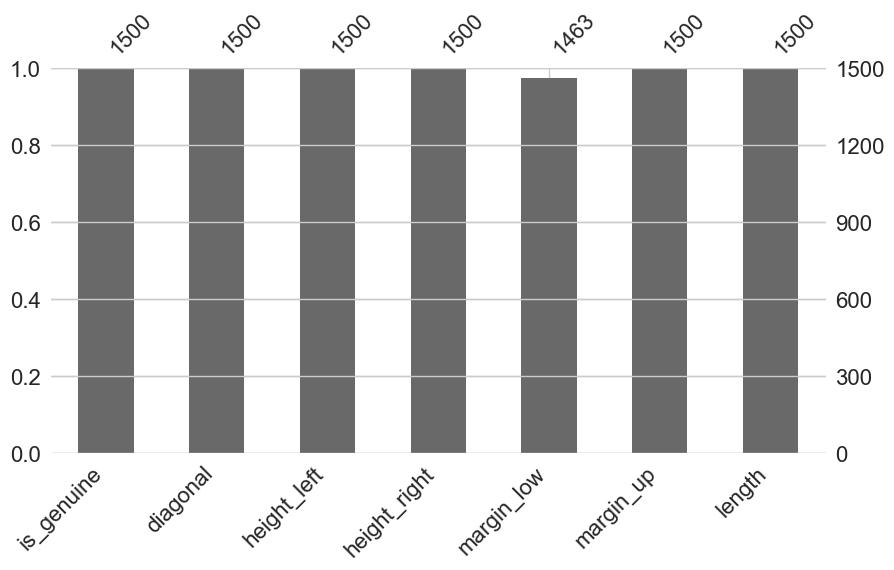

In [9]:
# A bar chart visualization of the nullity of the given DataFrame.
msno.bar(data, figsize=(10, 5));

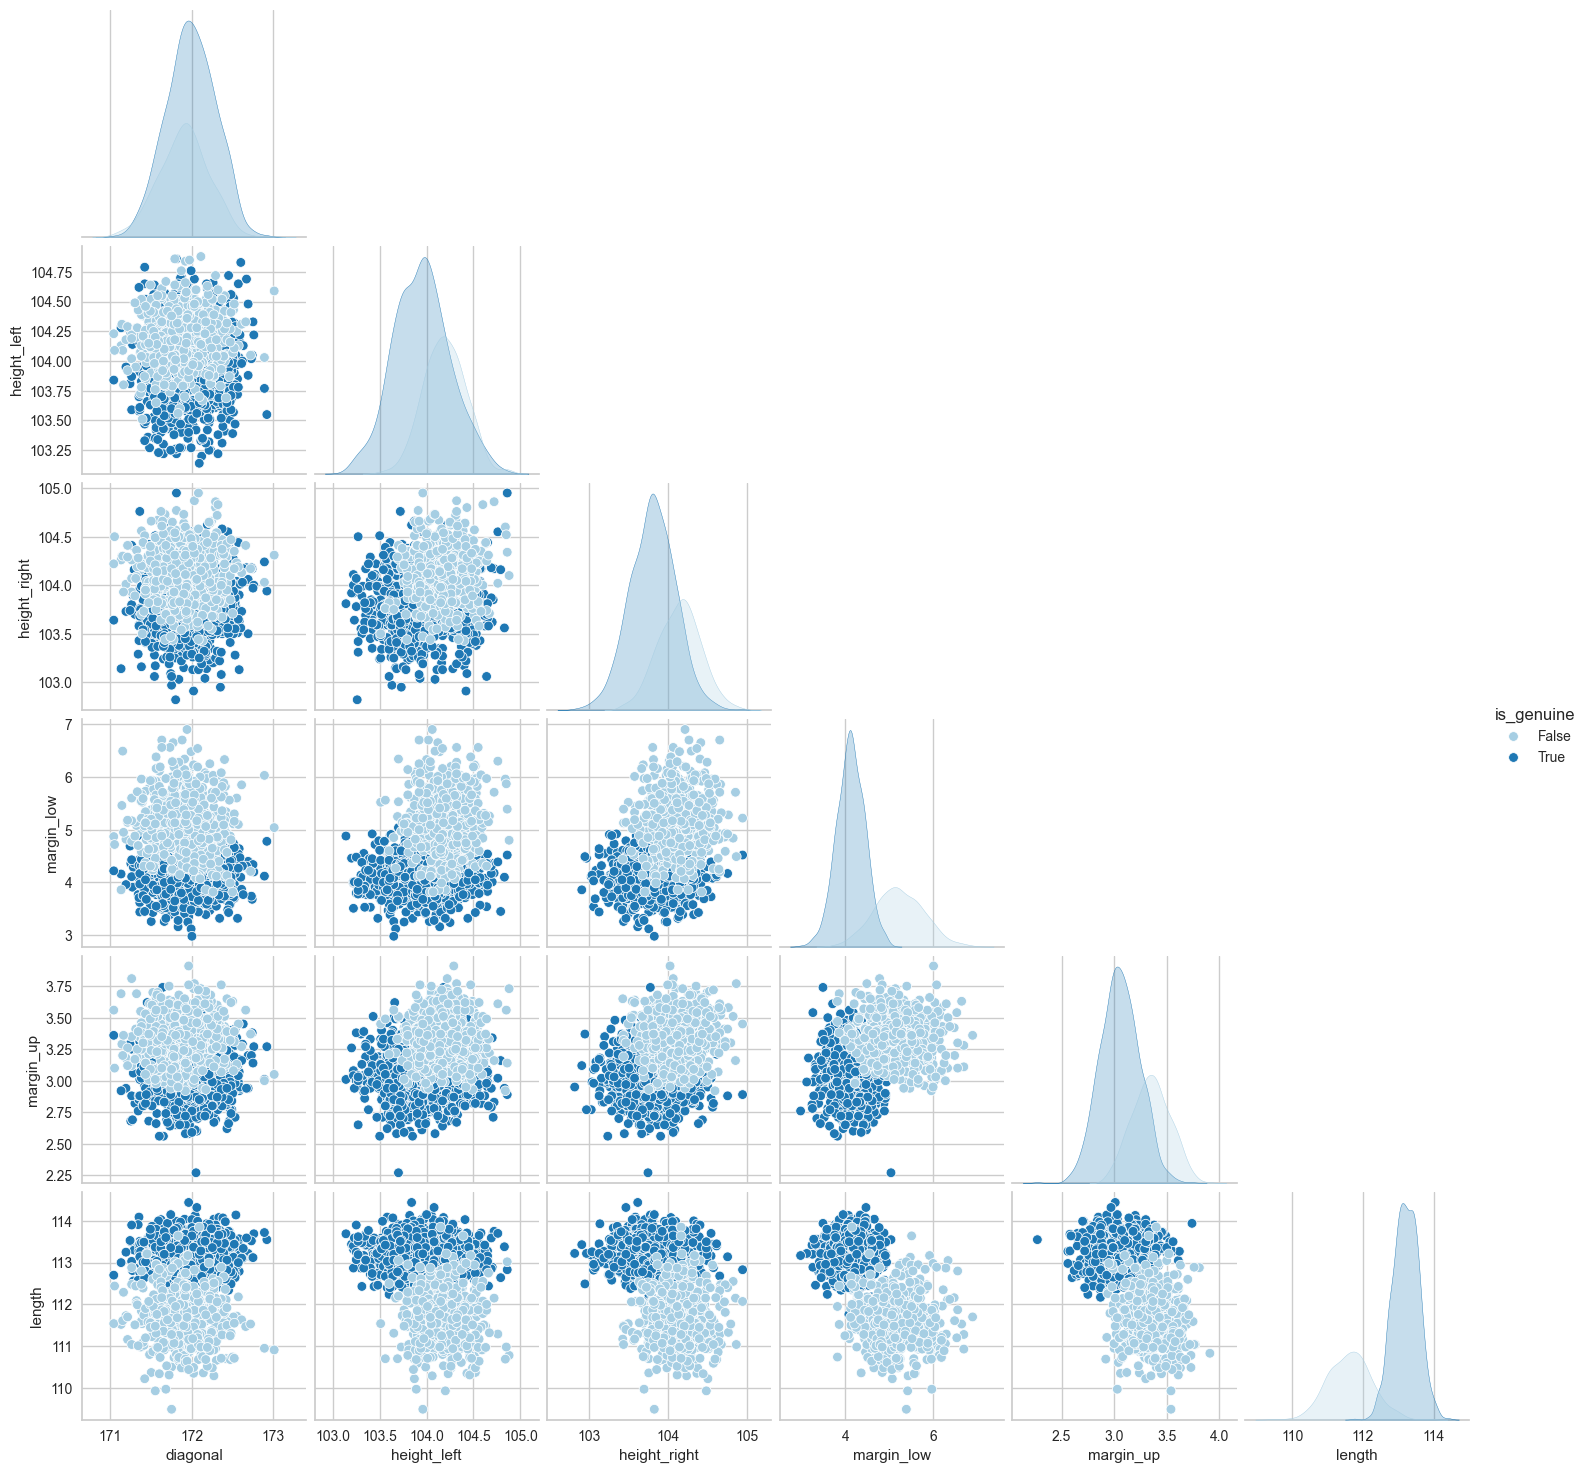

In [10]:
sns.pairplot(data, hue="is_genuine", palette="Paired", corner=True, diag_kind="kde");

In [11]:
# Generate a profile report from a Dataset stored as a pandas `DataFrame`.

profile = ProfileReport(data, title="Profiling Report")
profile.to_notebook_iframe()  # Used to output the HTML representation to a Jupyter notebook.
# profile.to_file("data_report.html")  # Write the report to a file.

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 116508.44it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Modeling

### Train & test split

In [12]:
X = data.drop("is_genuine", axis=1)  # toutes les données sauf la variable cible
y = data.loc[:, 'is_genuine']

In [13]:
X.head()

diagonal  height_left  height_right  margin_low  margin_up  length
0    171.81       104.86        104.95        4.52       2.89  112.83
1    171.46       103.36        103.66        3.77       2.99  113.09
2    172.69       104.48        103.50        4.40       2.94  113.16
3    171.36       103.91        103.94        3.62       3.01  113.51
4    171.73       104.28        103.46        4.04       3.48  112.54

In [14]:
y.value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

In [15]:
y.head()

0    True
1    True
2    True
3    True
4    True
Name: is_genuine, dtype: bool

In [16]:
# Séparons nos données en un jeu d'entraînement et un jeu de test :
# 30% des données dans le jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

logger.info(f"Train set - X: {X_train.shape} ; y: {y_train.shape} \nTest set - X: {X_test.shape} ; y: {y_test.shape}")

2025-10-02 09:45:36.737 | INFO     | __main__:<module>:5 - Train set - X: (1050, 6) ; y: (1050,) 
Test set - X: (450, 6) ; y: (450,)


In [17]:
y_train.value_counts(normalize=True)

is_genuine
True     0.666667
False    0.333333
Name: proportion, dtype: float64

In [18]:
y_test.value_counts(normalize=True)

is_genuine
True     0.666667
False    0.333333
Name: proportion, dtype: float64

### Logistic regression

In [19]:
# définition de Pipeline de régression avec Pipeline (c'est à nous de données les noms de chaque étape du workflow)
rl_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")),
                           ("scaler", MinMaxScaler()),
                           ("classifier", LogisticRegression(solver="saga")),
                          ]
                   )
rl_pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(solver='saga'))])

In [20]:
scores = cross_validate(rl_pipe, X_train, y_train, cv=5,
                        scoring=["f1_macro"],
                        return_train_score=True,
                        verbose=True,
                       )
pd.DataFrame(scores)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


fit_time  score_time  test_f1_macro  train_f1_macro
0  0.004925    0.002074       0.994624        0.982413
1  0.004211    0.004684       0.994624        0.985147
2  0.002566    0.001158       0.978252        0.987870
3  0.001877    0.001006       0.972918        0.990565
4  0.002072    0.000984       0.989208        0.983781

#### Train & analyze

In [21]:
rl_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(solver='saga'))])

In [22]:
y_train_pred =  rl_pipe.predict(X_train)
y_test_pred =  rl_pipe.predict(X_test)

In [23]:
# liste des labels prédits dans le modèle entrainé
class_names = rl_pipe.classes_
class_names

array([False,  True])

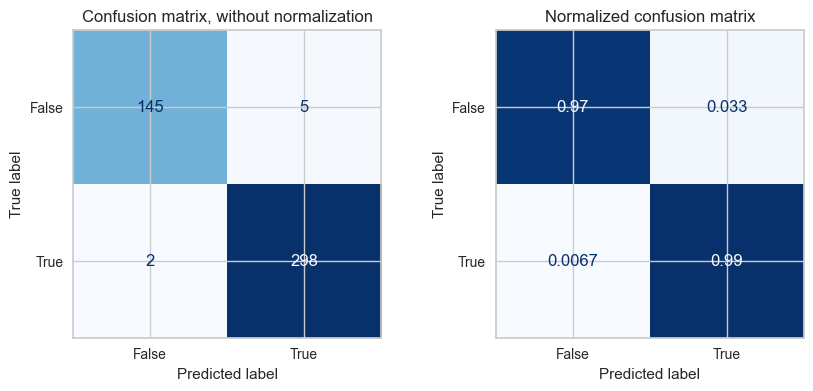

In [24]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 ligne, 2 colonnes

for ax, (title, normalize) in zip(axes, titles_options):
    disp_cm = ConfusionMatrixDisplay.from_estimator(
        rl_pipe,             # pipeline ou modèle entraîné
        X_test,              # données de test
        y_test,              # étiquettes réelles
        display_labels=class_names, # noms des classes
        cmap=plt.cm.Blues,   # colormap (nuances de bleu)
        normalize=normalize, # Normalisation des valeurs de matrice de confusion : 'true' (par ligne), 'pred' (par colonne), 'all' (sur l’ensemble), None = valeurs brutes
        ax=ax,               # tracer dans l'axe choisi
        colorbar=False,  # ne pas afficher la légende colorbar
    )
    ax.set_title(title) # Ajouter un titre pour chaque matrice

# Ajuster l'affichage et montrer les graphiques
plt.show()

In [25]:
# Rapport de classification
for name, y_true, y_pred in [("Train", y_train, y_train_pred),
                             ("Test", y_test, y_test_pred),
                            ]:
    print(f"{name} ==========================================\n")
    print(classification_report(y_true, y_pred), end="\n\n\n")

Train ==========================================

              precision    recall  f1-score   support

       False       1.00      0.97      0.98       350
        True       0.98      1.00      0.99       700

    accuracy                           0.99      1050
   macro avg       0.99      0.98      0.99      1050
weighted avg       0.99      0.99      0.99      1050



Test ==========================================

              precision    recall  f1-score   support

       False       0.99      0.97      0.98       150
        True       0.98      0.99      0.99       300

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450





/opt/anaconda3/envs/handson/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


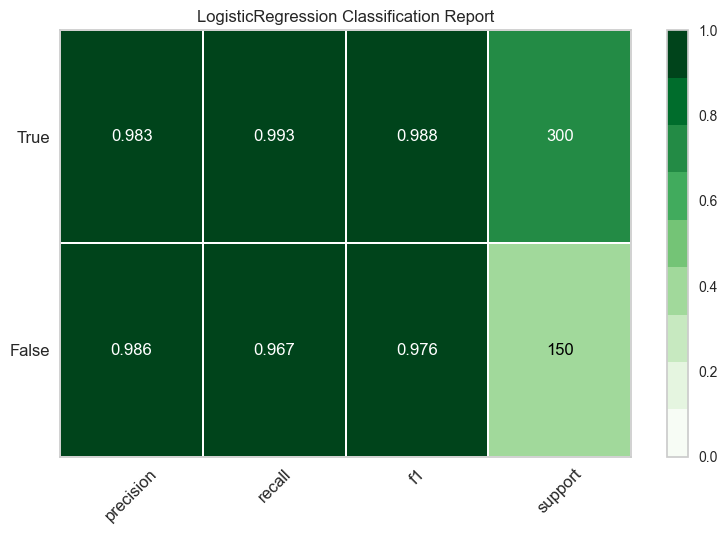

In [26]:
cr_visualizer = ClassificationReport(rl_pipe, classes=class_names, support=True, cmap="Greens")

cr_visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
cr_visualizer.score(X_test, y_test)        # Evaluate the model on the test data
cr_visualizer.show();                       # Finalize and show the figure

#### Optimization

##### Best probability threshold

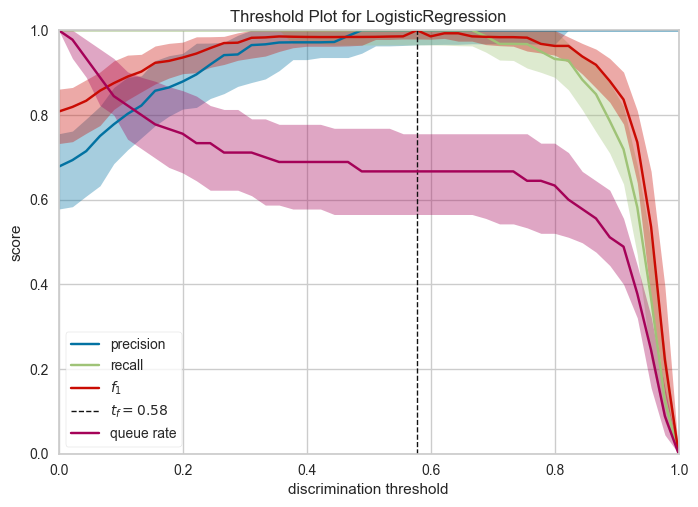

In [27]:
# Visualize the impact of the decision threshold on the performance of a binary classification model

rl_visualizer = DiscriminationThreshold(rl_pipe, is_fitted=True, random_state=RANDOM_STATE, argmax="fscore", fbeta=1.0)

rl_visualizer.fit(X_test, y_test)        # Fit the data to the visualizer
rl_visualizer.show();                    # Finalize and render the figure

**Métriques de performance (Precision, Recall, F1, Queue Rate)**

| Métrique       | Question posée                                          | Exemple (modèle de détection de faux billets)                       |
| -------------- | ------------------------------------------------------- | ------------------------------------------------------------------- |
| **Precision**  | Quand je prédis “faux billet”, ai-je souvent raison ?   | Sur 100 billets prédits comme faux → 80 étaient vraiment faux = 80% |
| **Recall**     | Ai-je retrouvé la majorité des faux billets réels ?     | Sur 100 faux billets existants → 75 détectés = 75%                  |
| **Queue Rate** | Quelle proportion totale est prédite en “faux billet” ? | 30% des billets sont signalés comme faux par le modèle              |
| **F1-score**   | Quel équilibre entre précision et rappel ?              | Combinaison précision/rappel = 0.69                                 |
| $t_f$          | Quel est le meilleur seil de probabilité ?              | Meuilleur seuil de probabilité                                      |


##### Tuning hyperparameters

In [28]:
rl_param_grid = {
    "classifier__fit_intercept": [True, False],
    # 'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    "classifier__penalty": ["none", "l1", "l2", "elasticnet"],
    "classifier__C": np.logspace(1e-2, 3, 7)
}

rl_grid_search = GridSearchCV(rl_pipe, rl_param_grid, cv=5, scoring="f1_macro", return_train_score=True)
rl_grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'classifier__C': array([   1.02329299,    3.223542  ,   10.15468992,   31.9889511 ,
        100.77048141,  317.44366652, 1000.        ]),
                         'classifier__fit_intercept': [True, False],
                         'classifier__penalty': ['none', 'l1', 'l2',
                                                 'elasticnet']},
             return_train_score=True, scoring='f1_macro')

In [29]:
rl_grid_search.fit(X_train, y_train)

/opt/anaconda3/envs/handson/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'classifier__C': array([   1.02329299,    3.223542  ,   10.15468992,   31.9889511 ,
        100.77048141,  317.44366652, 1000.        ]),
                         'classifier__fit_intercept': [True, False],
                         'classifier__penalty': ['none', 'l1', 'l2',
                                                 'elasticnet']},
             return_train_score=True, scoring='f1_macro')

In [30]:
rl_best_params = rl_grid_search.best_params_
logger.info(f"Best params: {rl_best_params}")

2025-10-02 09:45:38.865 | INFO     | __main__:<module>:2 - Best params: {'classifier__C': np.float64(3.2235420019524628), 'classifier__fit_intercept': True, 'classifier__penalty': 'l1'}


In [31]:
logger.info(f"Internal CV score: {rl_grid_search.best_score_: .3f}")

2025-10-02 09:45:38.900 | INFO     | __main__:<module>:1 - Internal CV score:  0.990


In [32]:
rl_grid_cv_results = rl_grid_search.cv_results_
pd.DataFrame(rl_grid_cv_results).head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.001281      0.000125         0.000000        0.000000   
1       0.006143      0.001255         0.001265        0.000176   
2       0.001974      0.000174         0.001080        0.000200   
3       0.001182      0.000123         0.000000        0.000000   
4       0.000926      0.000063         0.000000        0.000000   
5       0.003013      0.000063         0.001182        0.000087   
6       0.001736      0.000191         0.001209        0.000361   
7       0.000899      0.000046         0.000000        0.000000   
8       0.000841      0.000018         0.000000        0.000000   
9       0.005700      0.000088         0.001231        0.000101   

   param_classifier__C  param_classifier__fit_intercept  \
0             1.023293                             True   
1             1.023293                             True   
2             1.023293                             True   
3             1.023293                             True   
4             1.023293                            False   
5             1.023293                            False   
6             1.023293                            False   
7             1.023293                            False   
8             3.223542                             True   
9             3.223542                             True   

  param_classifier__penalty  \
0                      none   
1                        l1   
2                        l2   
3                elasticnet   
4                      none   
5                        l1   
6                        l2   
7                elasticnet   
8                      none   
9                        l1   

                                              params  split0_test_score  \
0  {'classifier__C': 1.023292992280754, 'classifi...                NaN   
1  {'classifier__C': 1.023292992280754, 'classifi...           1.000000   
2  {'classifier__C': 1.023292992280754, 'classifi...           0.994624   
3  {'classifier__C': 1.023292992280754, 'classifi...                NaN   
4  {'classifier__C': 1.023292992280754, 'classifi...                NaN   
5  {'classifier__C': 1.023292992280754, 'classifi...           1.000000   
6  {'classifier__C': 1.023292992280754, 'classifi...           0.994624   
7  {'classifier__C': 1.023292992280754, 'classifi...                NaN   
8  {'classifier__C': 3.2235420019524628, 'classif...                NaN   
9  {'classifier__C': 3.2235420019524628, 'classif...           1.000000   

   split1_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0                NaN  ...              NaN             NaN               29   
1           0.994624  ...         0.990314        0.009251                2   
2           0.994624  ...         0.985925        0.008834               27   
3                NaN  ...              NaN             NaN               29   
4                NaN  ...              NaN             NaN               29   
5           0.994624  ...         0.989215        0.011323                8   
6           0.989208  ...         0.984858        0.012079               28   
7                NaN  ...              NaN             NaN               29   
8                NaN  ...              NaN             NaN               29   
9           0.989286  ...         0.990338        0.007107                1   

   split0_train_score  split1_train_score  split2_train_score  \
0                 NaN                 NaN                 NaN   
1            0.987892            0.990583            0.991935   
2            0.982413            0.985147            0.987870   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   
5            0.987892            0.990583            0.991935   
6            0.983811            0.986534            0.986534   
7                 NaN                 NaN                

In [33]:
best_rl_pipe = rl_grid_search.best_estimator_
best_rl_pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('classifier',
                 LogisticRegression(C=np.float64(3.2235420019524628),
                                    penalty='l1', solver='saga'))])

/opt/anaconda3/envs/handson/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.

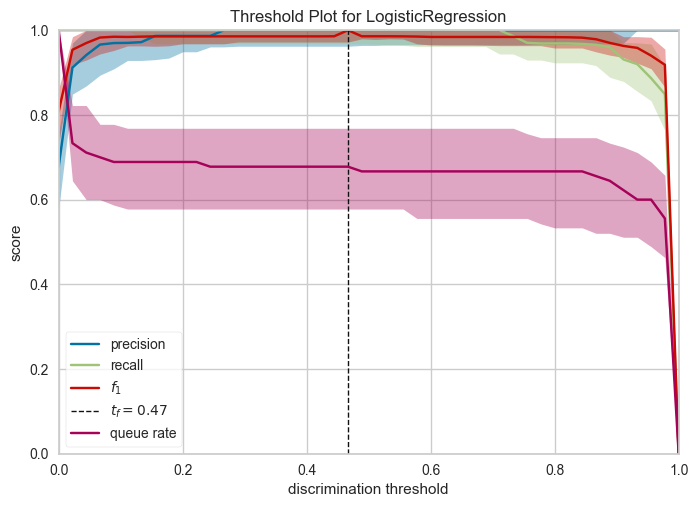

In [34]:
# Visualize the impact of the decision threshold on the performance of a binary classification model
rl_visualizer = DiscriminationThreshold(best_rl_pipe, is_fitted=True, random_state=RANDOM_STATE, argmax="fscore", fbeta=1.0)

rl_visualizer.fit(X_test, y_test)        # Fit the data to the visualizer
rl_visualizer.show();                    # Finalize and render the figure

In [35]:
# Extract fscore
lr_fscores = rl_visualizer.cv_scores_["fscore"]
lr_best_idx = lr_fscores.argmax()  # Find best score index
    
lr_best_threshold = rl_visualizer.thresholds_[lr_best_idx]  # optimal threshold Proba(y=True)

logger.info(f"Best proba threshold (according to F1-score) : {lr_best_threshold}")
logger.info(f"F1-score associated :", lr_fscores[lr_best_idx])

2025-10-02 09:45:40.147 | INFO     | __main__:<module>:7 - Best proba threshold (according to F1-score) : 0.4666666666666667
2025-10-02 09:45:40.149 | INFO     | __main__:<module>:8 - F1-score associated :


In [36]:
lr_y_pred_thresh = predict_with_threshold(best_rl_pipe, X_test, threshold=lr_best_threshold)

2025-10-02 09:45:40.173 | INFO     | src.utils:predict_with_threshold:38 - Retrieve the probabilities for the Positive class


In [37]:
print(classification_report(y_test, lr_y_pred_thresh))

              precision    recall  f1-score   support

       False       0.99      0.98      0.99       150
        True       0.99      1.00      0.99       300

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



#### Features importances

In [112]:
df_feature_importance = pd.DataFrame(best_rl_pipe[-1].coef_[0],  # coefficients du modèle logistique
                                     columns=["coef"], # Noms des colonnes du dataframe créé
                                     index=rl_grid_search.feature_names_in_, # Nom des lignes du dataframe créé
                                    )
logger.info(f"Shape: {df_feature_importance.shape}")
df_feature_importance.head()

2025-10-02 10:34:50.268 | INFO     | __main__:<module>:5 - Shape: (6, 1)


coef
diagonal       0.352259
height_left   -1.511592
height_right  -4.220975
margin_low   -16.354648
margin_up    -10.516410

In [ ]:
# top30 most important features
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending=True)
 .plot(kind="barh", figsize=(10, 5))
)
plt.title("Logistic regression")
plt.axvline(x=0, color='.6')
plt.subplots_adjust(left=.3);

#### Exercice:

Vous devez re-entraîner un **modèle de regression logistique** (détection de faux billets) et optimiser à la fois:

- Les hyperparamètres du modèle
- Le seuil de probabilité utilisé pour la prédiction finale

## Decision Tree

### Define pipeline

In [41]:
dt_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")),
                           ("scaler", MinMaxScaler()),
                           ("classifier", DecisionTreeClassifier()),
                          ]
                   )

### Optimization

In [44]:
dt_param_grid = {
            "classifier__max_depth": [3, 5, 10, None],
            "classifier__min_samples_split": [2, 5, 10]
        }

dt_grid_search = GridSearchCV(dt_pipe, dt_param_grid, cv=5, scoring="f1_macro", return_train_score=True)
dt_grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__max_depth': [3, 5, 10, None],
                         'classifier__min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='f1_macro')

In [51]:
dt_pipe_optimize = optimize_model(dt_pipe, dt_param_grid, X_train, y_train, scoring="f1_macro", cv=5)
dt_pipe_optimize

2025-10-02 09:51:24.001 | INFO     | src.optimizer:optimize_model:34 - Meilleurs paramètres: {'classifier__max_depth': None, 'classifier__min_samples_split': 5}
2025-10-02 09:51:24.002 | INFO     | src.optimizer:optimize_model:35 - Score validation (moyenne CV): 0.9797


{'best_params': {'classifier__max_depth': None,
  'classifier__min_samples_split': 5},
 'best_score': np.float64(0.9797124656064898),
 'best_model': Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                 ('classifier', DecisionTreeClassifier(min_samples_split=5))])}

In [46]:
best_dt_pipe = dt_pipe_optimize["best_model"]
best_dt_pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('classifier', DecisionTreeClassifier())])

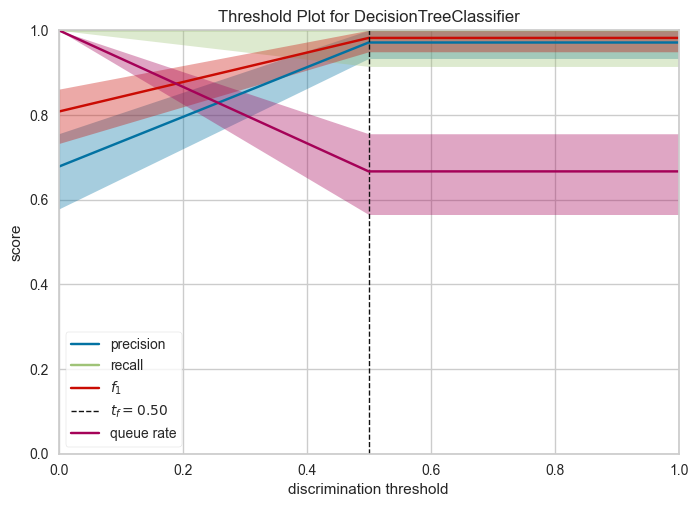

In [52]:
# Visualize the impact of the decision threshold on the performance of a binary classification model
dt_visualizer = DiscriminationThreshold(best_dt_pipe, is_fitted=True, random_state=RANDOM_STATE, argmax="fscore", fbeta=1.0)

dt_visualizer.fit(X_test, y_test)        # Fit the data to the visualizer
dt_visualizer.show();                    # Finalize and render the figure

In [95]:
# Best proba threshold
dt_best_threshold = get_best_trheshold(dt_visualizer, scoring="fscore")

2025-10-02 10:22:41.664 | INFO     | src.utils:get_best_trheshold:14 - Best proba threshold (according to F1-score) : 0.5
2025-10-02 10:22:41.712 | INFO     | src.utils:get_best_trheshold:15 - F1-score associated : 0.982


### Performance analysis

In [94]:
dt_y_pred_thresh = predict_with_threshold(best_dt_pipe, X_test, threshold=dt_best_threshold)

2025-10-02 10:22:35.804 | INFO     | src.utils:predict_with_threshold:38 - Retrieve the label with Positive class (1) >=0.5


In [55]:
print(classification_report(y_test, dt_y_pred_thresh))

              precision    recall  f1-score   support

       False       0.95      0.98      0.96       150
        True       0.99      0.97      0.98       300

    accuracy                           0.98       450
   macro avg       0.97      0.98      0.97       450
weighted avg       0.98      0.98      0.98       450



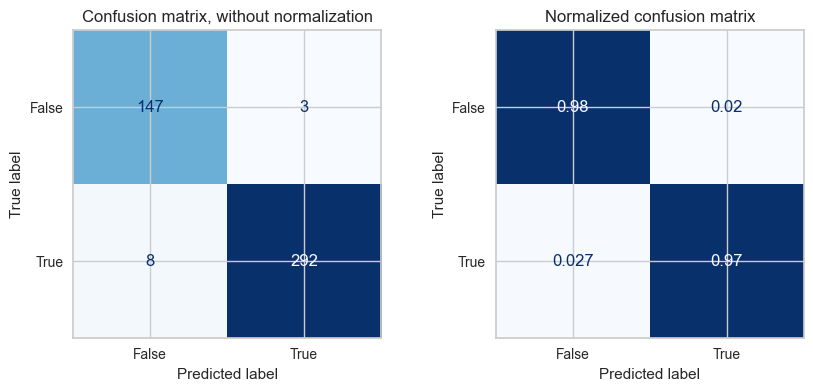

In [96]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 ligne, 2 colonnes

for ax, (title, normalize) in zip(axes, titles_options):
    disp_cm = ConfusionMatrixDisplay.from_estimator(
        best_dt_pipe,             # pipeline ou modèle entraîné
        X_test,              # données de test
        y_test,              # étiquettes réelles
        display_labels=class_names, # noms des classes
        cmap=plt.cm.Blues,   # colormap (nuances de bleu)
        normalize=normalize, # Normalisation des valeurs de matrice de confusion : 'true' (par ligne), 'pred' (par colonne), 'all' (sur l’ensemble), None = valeurs brutes
        ax=ax,               # tracer dans l'axe choisi
        colorbar=False,  # ne pas afficher la légende colorbar
    )
    ax.set_title(title) # Ajouter un titre pour chaque matrice

# Ajuster l'affichage et montrer les graphiques
plt.show()

### Features importances

**Étapes du processus**

- **Entraîner un modèle**
    - Exemple : un Decision Tree qui prédit si un billet est faux ou vrai à partir de ses caractéristiques (taille, couleur, épaisseur, etc.).

- Mesurer la performance initiale
    - Le modèle a un score de départ (par ex. F1 = 0.90).

- **Choisir une feature à tester**
    - Exemple : "épaisseur du billet".

- **Mélanger cette feature**
    - On garde toutes les autres colonnes identiques, mais on mélange les valeurs d’"épaisseur" → comme si on donnait au modèle une variable bruitée qui n’a plus de sens.

- **Recalculer la performance**
    - Si le score chute beaucoup (ex: F1 = 0.70 au lieu de 0.90) → ça veut dire que "épaisseur" est très importante.
    - Si le score reste presque pareil (ex: F1 = 0.89) → ça veut dire que "épaisseur" n’est pas utile.

- **Répéter pour toutes les variables**
    - On répète ce processus pour chaque colonne → et on obtient un classement des variables les plus importantes.

In [109]:
dt_feat_importance = permutation_importance(# calcule l’importance des features par permutation.
    best_dt_pipe, 
    X_test, y_test,  # dataset test
    n_repeats=10,  # Combien de fois on mélange chaque feature (pour stabilité)
    scoring="f1",  # Métrique utilisée pour mesurer la baisse de performance
    random_state=RANDOM_STATE,
)

dt_importances = pd.DataFrame({
    "feature": best_dt_pipe[0].get_feature_names_out(),
    "importance_mean": dt_feat_importance.importances_mean,
    "importance_std": dt_feat_importance.importances_std,
}).sort_values(by="importance_mean", ascending=False)

dt_importances.head()

feature  importance_mean  importance_std
5        length         0.221111        0.015404
3    margin_low         0.138222        0.007813
4     margin_up         0.047111        0.008061
1   height_left         0.004889        0.002948
2  height_right         0.001333        0.001778

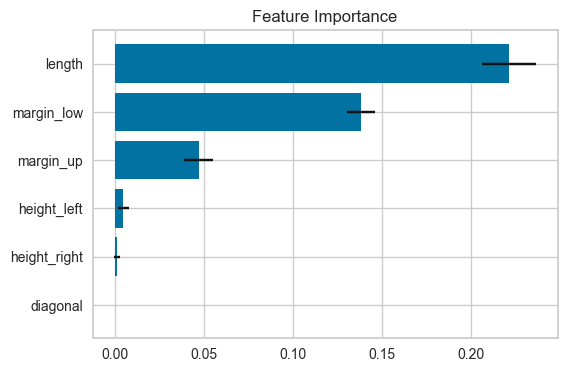

In [111]:
plt.figure(figsize=(6, 4))
plt.barh(dt_importances["feature"], dt_importances["importance_mean"], xerr=dt_importances["importance_std"])
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## KNN

### Define pipeline

In [56]:
knn_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")),
                           ("scaler", MinMaxScaler()),
                           ("classifier", KNeighborsClassifier()),
                          ]
                   )

### Optimization

In [57]:
knn_param_grid = {
        "classifier__n_neighbors": [3, 5, 7, 11],
        "classifier__weights": ["uniform", "distance"],
        "classifier__metric": ["euclidean", "manhattan"],
    }

In [58]:
knn_pipe_optimize = optimize_model(knn_pipe, knn_param_grid, X_train, y_train, scoring="f1_macro", cv=5)
knn_pipe_optimize

2025-10-02 09:51:40.109 | INFO     | src.optimizer:optimize_model:34 - Meilleurs paramètres: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
2025-10-02 09:51:40.110 | INFO     | src.optimizer:optimize_model:35 - Score validation (moyenne CV): 0.9903


{'best_params': {'classifier__metric': 'euclidean',
  'classifier__n_neighbors': 7,
  'classifier__weights': 'uniform'},
 'best_score': np.float64(0.9903144303536566),
 'best_model': Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                 ('classifier',
                  KNeighborsClassifier(metric='euclidean', n_neighbors=7))])}

In [59]:
best_knn_pipe = knn_pipe_optimize["best_model"]
best_knn_pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=7))])

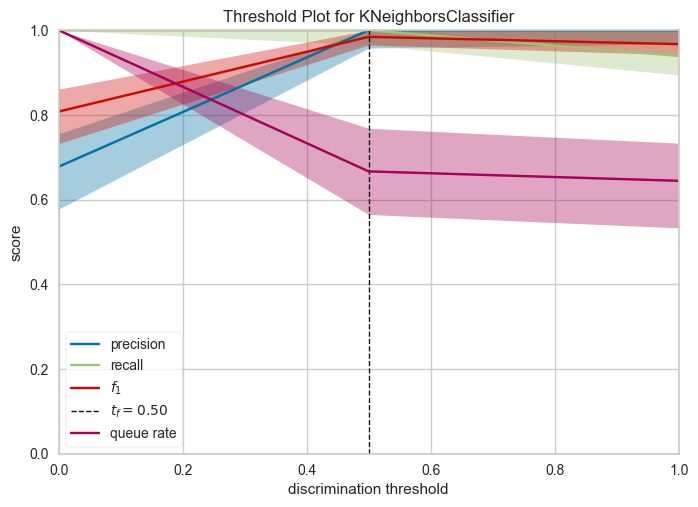

In [60]:
# Visualize the impact of the decision threshold on the performance of a binary classification model
knn_visualizer = DiscriminationThreshold(best_knn_pipe, is_fitted=True, random_state=RANDOM_STATE, argmax="fscore", fbeta=1.0)

knn_visualizer.fit(X_test, y_test)        # Fit the data to the visualizer
knn_visualizer.show();                    # Finalize and render the figure

In [64]:
knn_best_threshold = get_best_trheshold(knn_visualizer, scoring="fscore")

2025-10-02 09:52:37.001 | INFO     | src.utils:get_best_trheshold:14 - Best proba threshold (according to F1-score) : 0.5
2025-10-02 09:52:37.008 | INFO     | src.utils:get_best_trheshold:15 - F1-score associated : 0.984


### Performance analysis

In [65]:
knn_y_pred_thresh = predict_with_threshold(best_knn_pipe, X_test, threshold=knn_best_threshold)
print(classification_report(y_test, knn_y_pred_thresh))

2025-10-02 09:52:37.209 | INFO     | src.utils:predict_with_threshold:38 - Retrieve the probabilities for the Positive class


              precision    recall  f1-score   support

       False       0.99      0.97      0.98       150
        True       0.99      1.00      0.99       300

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



### Features importances

## Ensembliste methods

### XGBoost

In [70]:
xgb_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")),
                           ("scaler", MinMaxScaler()),
                           ("classifier", XGBClassifier(objective="binary:logistic",  # classification binaire
                                                        eval_metric="logloss",        # métrique interne d’optimisation de XGBoost
                                                        random_state=RANDOM_STATE,    # pour la reproductibilité
                                                       )),
                          ]
                   )

In [71]:
xgb_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__subsample": [0.8, 1.0]
}

In [72]:
xgb_pipe_optimize = optimize_model(xgb_pipe, xgb_param_grid, X_train, y_train, scoring="f1_macro", cv=5)
xgb_pipe_optimize

2025-10-02 10:01:16.946 | INFO     | src.optimizer:optimize_model:34 - Meilleurs paramètres: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
2025-10-02 10:01:16.951 | INFO     | src.optimizer:optimize_model:35 - Score validation (moyenne CV): 0.9882


{'best_params': {'classifier__learning_rate': 0.1,
  'classifier__max_depth': 5,
  'classifier__n_estimators': 200,
  'classifier__subsample': 1.0},
 'best_score': np.float64(0.9882101719364028),
 'best_model': Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                 ('classifier',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric='logloss',
                                feature_types=None, feature_weights=None,
                                gamma=None, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=0.1,
                                max_bin=None,

In [74]:
best_xgb_pipe = xgb_pipe_optimize["best_model"]
best_xgb_pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

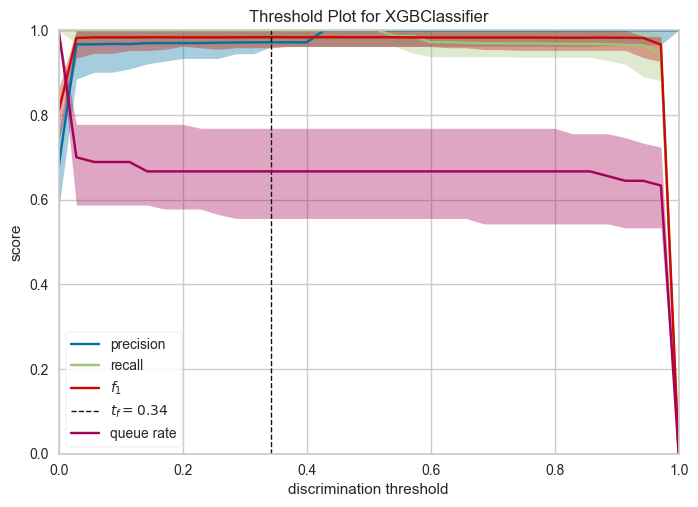

In [75]:
# Visualize the impact of the decision threshold on the performance of a binary classification model
xgb_visualizer = DiscriminationThreshold(best_xgb_pipe, is_fitted=True, random_state=RANDOM_STATE, argmax="fscore", fbeta=1.0)

xgb_visualizer.fit(X_test, y_test)        # Fit the data to the visualizer
xgb_visualizer.show();                    # Finalize and render the figure

In [80]:
xgb_best_threshold = get_best_trheshold(xgb_visualizer, scoring="fscore")

2025-10-02 10:03:27.023 | INFO     | src.utils:get_best_trheshold:14 - Best proba threshold (according to F1-score) : 0.3429
2025-10-02 10:03:27.462 | INFO     | src.utils:get_best_trheshold:15 - F1-score associated : 0.984


In [93]:
xgb_y_pred_thresh = predict_with_threshold(best_xgb_pipe, X_test, threshold=xgb_best_threshold)
print(classification_report(y_test, xgb_y_pred_thresh))

2025-10-02 10:10:30.726 | INFO     | src.utils:predict_with_threshold:38 - Retrieve the probabilities for the Positive class


              precision    recall  f1-score   support

       False       0.98      0.97      0.98       150
        True       0.99      0.99      0.99       300

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



### LightGBM

In [85]:
lgbm_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")),
                            ("scaler", MinMaxScaler()),
                            ("classifier", LGBMClassifier(
                                objective="binary",   # classification binaire
                                metric="binary_logloss",  # métrique interne (vous pouvez mettre aussi 'auc', 'f1' si besoin)
                                random_state=RANDOM_STATE       # graine pour reproductibilité),
                            ))]
                    )

In [86]:
lgbm_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [-1, 5, 10],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__num_leaves": [31, 63]
}

# Exercice : 
- Optimiser le model avec ces paramètres
- Analyser les performances du modèle optimisé